# Module 3
## Model development of thermocouple response

We now have all the tools to reanalyze the velocimetry combined with thermocouple data to try and develop a model of the thermocouple dynamic response.  From that model, we will be able to infer what the real temperature profile would have been.

![title](img/DCC1_lag_corrected1_raw.png)

The velocity data are acquired with a non-intrusive laser based technique called Molecular Tagging Velocimetry (MTV).  In addition to being non-intrusive, this technique is minimally perturbative as the tracers are molecules.  The latter have no inertia at the speed considered here and the technique can be considered an ideal $0^{th}$ order dynamic system.  Because of this instantaneous response, the velocity will be considered the forcing function.

\begin{align*}
V(t) = K_v F(t)
\end{align*}
here $F(t)$ is the forcing function.  The velocity is directly proportional to the forcing function through the static sensitivity constant $K_V$.

Thermocouple dynamic response can be described analytically with a first order dynamic system. 

\begin{align*}
\tau \frac{d y}{dt} + y = K F(t)
\end{align*}

Neglecting the conduction through the thermcouple wires, the time constant can be shown to be:

\begin{align*}
\tau = \frac{mC}{h_{sf}A_s}
\end{align*}
with $m$: mass of thermocouple, $C$ specific heat of the thermcouple, $h_{sf}$ convection heat transfer coefficient from fluid to the sensor, and $A_s$ sensing or wetted surface area of the thermcouple.  

In the data here, the time constant has been estimated to be $\tau \approx 90$ s with the model above.  However, the model is very conservative and we do not know the actual time constant.  Using the velocity time history as a forcing function, let's estimate the time constant.  This can be accomplished by numerically integrating the velocity history in the ode or by using Fourier transforms.  Let's use this second approach.

### Derivation of ode in Fourier/frequency domain

\begin{align*}
\tau \frac{d y}{dt} + y = K F(t)
\end{align*}

### Harmonic response of first order dynamic system to sinusoidal-input

This was seen in the previous module and has been slightly updated here. 

Because, here one needs to consider that the forcing of each harmonic will have a dedicated phase $\Phi$.  it is easier to do this using complex notation: $F, \,y$ are complex.  So the $k^{th}$ harmonic of the force is $F_{\omega_k}(t) = A_k \mathrm{e}^ {\omega_k t}$, with $\omega_k=2\pi f_k$ the radiant frequency of each harmonic, $A_k$ is complex and includes the phase information in it, $\Phi = \tan^{-1} \frac{\Im{A_k}}{\Re{A_k}}$.

After some math, the solution of the $k^{th}$ harmonic to the ode:

\begin{align*}
y_k(t) = \left( y_0 - \frac{KA_k}{1+\omega_k^2 \tau^2} \left( 1 - i \omega_k \tau \right) \right) e^{-t/\tau} + \frac{KA_k}{1+\omega_k^2\tau^2} (1-i \omega_k \tau) \mathrm{e}^{i \omega_k t} 
\end{align*}
with the steady state phase with respect to the forcing:
\begin{align*}
\phi_k = \tan^{-1}\left( \frac{\Im{(1-i\omega_k \tau)}}{\Re{(1-i\omega_k \tau)}} \right) = \tan^{-1}(-\omega_k \tau) = -\tan^{-1}(\omega_k \tau)
\end{align*}

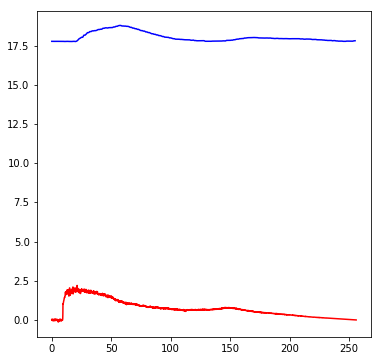

In [132]:
import numpy
from matplotlib import pyplot
%matplotlib inline
import csv
import math 

dummy_t_V = []
dummy_V = []
with open('data/V_mod.csv') as csvfile_V:
    readCSV = csv.reader(csvfile_V, delimiter=',')
    for row in readCSV:
        dummy_t_V.append(row[0])
        dummy_V.append(row[1])

# time is reported in seconds.  Data were recorded at 10 Hz.
t_V = [float(i) for i in dummy_t_V]
V = [float(i) for i in dummy_V]
f_s_V = 10 # sampling frequency for velocity (Hz)

dummy_t_TK = []
dummy_TK = []
with open('data/TK_mod.csv') as csvfile_T:
    readCSV = csv.reader(csvfile_T, delimiter=',')
    for row in readCSV:
        dummy_t_TK.append(row[0])
        dummy_TK.append(row[1])

# time is reported in seconds.  Data were recorded at 1 Hz.
t_TK = [float(i) for i in dummy_t_TK] # time vector
TK = [float(i) for i in dummy_TK] # temperature vector
f_s_TK = 1 # sampling frequency for temperature (Hz)

fig = pyplot.figure(figsize=(6,6))
pyplot.plot(t_V, V,'r')
pyplot.plot(t_TK, TK,'b');

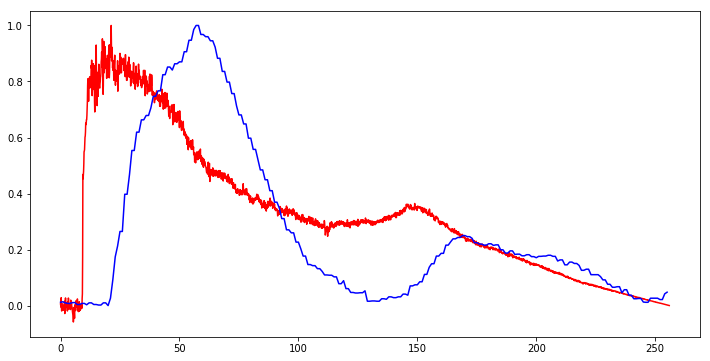

In [133]:
# Normalize values to display on same graph
# select number of points to treat.  Will take 256 s for temperature
N_V = int(N_TK * f_s_V/f_s_TK)
V = (V)/(numpy.max(V[0:N_V]))

N_TK = 256
TK = (TK-numpy.min(TK[0:N_TK]))/(numpy.max(TK[0:N_TK])-numpy.min(TK[0:N_TK]))

fig = pyplot.figure(figsize=(12,6))
pyplot.plot(t_V[0:N_V], V[0:N_V],'r')
pyplot.plot(t_TK[0:N_TK], TK[0:N_TK],'b');

To help with the analysis, we are going to make the data periodic with 0 mean by extending and  inverting the data.

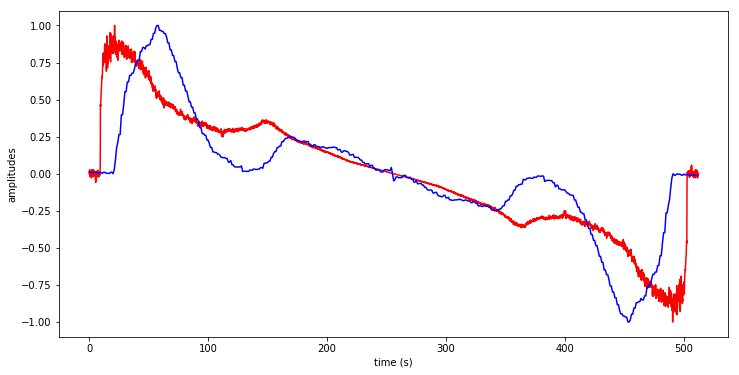

In [134]:
V2 = numpy.zeros(2*N_V)
V2[0:N_V-1] = V[0:N_V-1]
t_V2 = numpy.linspace(0,2*N_V-1, num=2*N_V)/10
for i in range(N_V):
    V2[N_V+i] = -V[N_V-1-i]

TK2 = numpy.zeros(2*N_TK)
TK2[0:N_TK-1] = TK[0:N_TK-1]
t_TK2 = numpy.linspace(0,2*N_TK-1, num=2*N_TK)
for i in range(N_TK):
    TK2[N_TK+i] = -TK[N_TK-1-i]

fig = pyplot.figure(figsize=(12,6))
pyplot.plot(t_V2, V2,'r')
pyplot.plot(t_TK2, TK2,'b')
pyplot.ylabel('amplitudes');
pyplot.xlabel('time (s)');


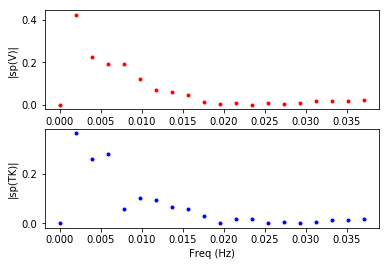

In [135]:
sp_TK2 = numpy.fft.fft(TK2) # compute FFT of TK
sp_V2 = numpy.fft.fft(V2) # compute FFT of V

k_TK2 = numpy.arange(2*N_TK)
frq_TK2 = k_TK2/(2*N_TK/f_s_TK) # two sides frequency raVe
frq_TK2 = frq_TK2[range(int(N_TK))] # one side frequency range
sp1_TK2 = sp_TK2[range(int(N_TK))]  # one side spectrum

k_V2 = numpy.arange(2*N_V)
frq_V2 = k_V2/(2*N_V/f_s_V) # two sides frequency range
frq_V2 = frq_V2[range(int(N_V))] # one side frequency range
sp1_V2 = sp_V2[range(int(N_V))] # one side spectrum

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(frq_V2[0:20],abs(sp1_V2[0:20])*2/(2*N_V),'r.'); # plotting the spectrum
ax[0].set_ylabel('|sp(V)|');
ax[1].plot(frq_TK2[0:20],abs(sp1_TK2[0:20])*2/(2*N_TK),'b.') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|sp(TK)|');


Let's see how many harmonics it takes to reproduce the signals.

We are going to define a filter which has value 1 for the harmonic we keep and 0 for the harmonic we reject and we will multiply the filter with the  FFT.  In essence, this is an ideal low pass filter.  

When filtering the data, we have to be careful that we keep both the positive and negative frequencies.  Could you justify why?

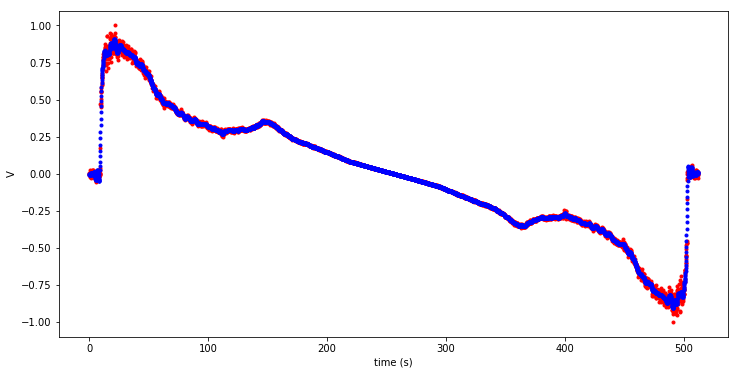

In [136]:
# filter spectrum to only keep first n harmonics
n_filt = 200
filt = numpy.zeros(2*N_V)
filt[0] = 1
for i in range(n_filt):
    filt[i+1] = 1
    filt[2*N_V-1-i] = 1

sp_V2_filt = numpy.multiply(filt,sp_V2)
#print(isp_filt)

isp_V2 = numpy.fft.ifft(sp_V2_filt) # Computer inverse FFT, here we have to take ALL the frequencies

fig = pyplot.figure(figsize=(12,6))
pyplot.plot(t_V2,V2,'r.')
pyplot.plot(t_V2, isp_V2.real,'b.') # plotting the IFFT (keeping only real part, imaginary should be 0 anyway).
pyplot.xlabel('time (s)')
pyplot.ylabel('V');

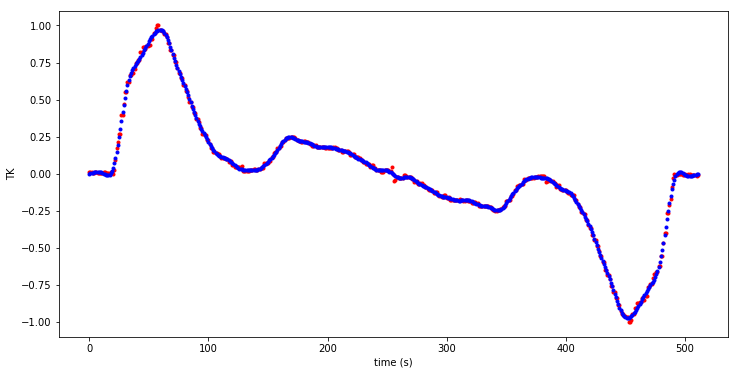

In [137]:
# filter spectrum to only keep first n harmonics
n_filt = 30
filt = numpy.zeros(2*N_TK)
filt[0] = 1
for i in range(n_filt):
    filt[i+1] = 1
    filt[2*N_TK-1-i] = 1

sp_TK2_filt = numpy.multiply(filt,sp_TK2)
isp_TK2 = numpy.fft.ifft(sp_TK2_filt) # Computer inverse FFT, here we have to take ALL the frequencies

fig = pyplot.figure(figsize=(12,6))
pyplot.plot(t_TK2,TK2,'r.')
pyplot.plot(t_TK2, isp_TK2.real,'b.') # plotting the IFFT (keeping only real part, imaginary should be 0 anyway).
pyplot.ylabel('TK')
pyplot.xlabel('time (s)');

In [138]:
import cmath

def y_sin(t,T,tau,y_0,K,A):
   ''' Calculate the output of a first order ode when forcing function is 
   a sine wave of frequency f with phase phi
   Arguments
   ---------
   t: time (in second)
   T : period of the forcing sine wave (s)
   tau: time constant of the system (s)
   K: static sensitivity (dimensionless)
   A: amplitude of forcing (unit of F), complex number
   Returns
   -------
   y_sin : Output of 1st order ode, see eqn above.
   '''    
   omega = 2*numpy.pi/T # convert f to radial frequency
   phi = -numpy.arctan(omega*tau) 
   y_sin = (y_0 - K*A/(1+omega**2*tau**2)*(1-1j*omega*tau))*numpy.exp(-t/tau) \
    + K*A/(1+omega**2*tau**2) * (1-1j*omega*tau) * numpy.exp(1j*omega*t)
   
   return y_sin

tau = 15 # estimated time constant (s)
y_0 = 0
K = 1
t=numpy.linspace(0.0,511.9,num=5120) # (s)


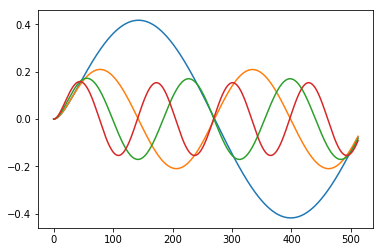

In [139]:
# plot first 5 harmonics
for i in range(1,5): #n_filt):
    T_s2 = 2*N_V/(i*f_s_V)
    A_k = sp_V2_filt[i]*2/(2*N_V)
    y_out = y_sin(t,T_s2,tau,y_0,K,A_k)
    pyplot.plot(t, y_out.real); # output


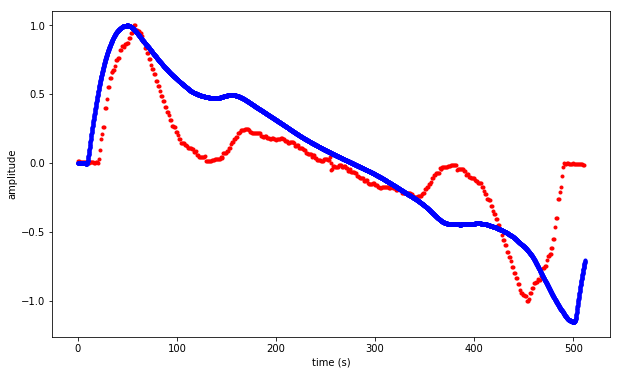

In [140]:
tau = 20 # estimated time constant (s)
N_harmonics = 400
y_reconstructed = numpy.zeros(2*N_V)
for i in range(1, N_harmonics): #n_filt):
    T_s2 = 2*N_V/(i*f_s_V)
    A_k = sp_V2_filt[i]*2/(2*N_V)
    y_reconstructed = y_reconstructed + y_sin(t,T_s2,tau,y_0,K,A_k)

y_reconstructed = y_reconstructed 

fig = pyplot.figure(figsize=(10,6))
pyplot.plot(t_TK2,TK2.real,'r.')
# normalize the reconstructed temperature
pyplot.plot(t,y_reconstructed.real/numpy.max(y_reconstructed.real),'b.');
pyplot.xlabel('time (s)')
pyplot.ylabel('amplitude');

Let's comment on the overal shape, similarities and differences.  How could you explain the discrepancies.

### We can now redo the analysis without making the original function periodic

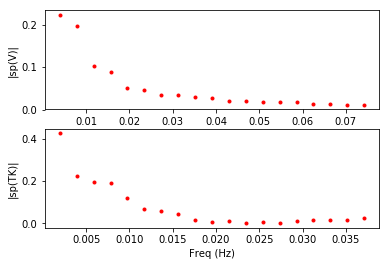

In [141]:
sp_V = numpy.fft.fft(V) # compute FFT of V
sp_TK = numpy.fft.fft(TK) # compute FFT of TK

k_TK = numpy.arange(N_TK)
frq_TK = k_TK/(N_TK/f_s_TK) # two sides frequency raVe
frq_TK = frq_TK[range(int(N_TK/2))] # one side frequency range
sp1_TK = sp_TK[range(int(N_TK/2))]

k_V = numpy.arange(N_V)
frq_V = k_V/(N_V/f_s_V) # two sides frequency range
frq_V = frq_V[range(int(N_V/2))] # one side frequency range
sp1_V = sp_V[range(int(N_V/2))]

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(frq_V[1:20],abs(sp1_V[1:20])*2/(N_V),'r.') # plotting the spectrum
ax[0].set_ylabel('|sp(V)|');
ax[1].plot(frq_V2[1:20],abs(sp1_V2[1:20])*2/(2*N_V),'r.'); # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|sp(TK)|');


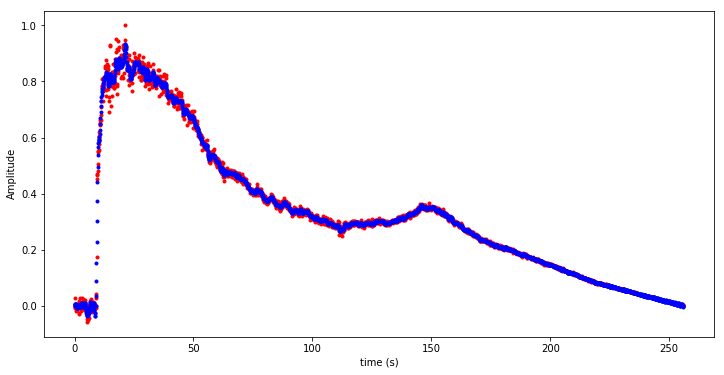

In [142]:
# filter velocity spectrum to only keep first n harmonics
n_filt = 200
filt = numpy.zeros(N_V)
filt[0] = 1
for i in range(n_filt):
    filt[i+1] = 1
    filt[N_V-1-i] = 1

sp_V_filt = numpy.multiply(filt,sp_V)

isp_V = numpy.fft.ifft(sp_V_filt) # Computer inverse FFT, here we have to take ALL the frequencies

fig = pyplot.figure(figsize=(12,6))
pyplot.plot(t_V,V,'r.')
pyplot.plot(t_V, isp_V.real,'b.') # plotting the IFFT (keeping only real part, imaginary should be 0 anyway).
pyplot.xlabel('time (s)')
pyplot.ylabel('Amplitude');

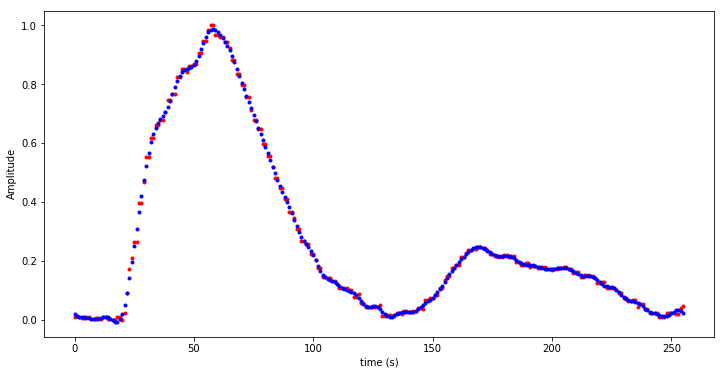

In [143]:
# filter spectrum to only keep first n harmonics
n_filt = 30
filt = numpy.zeros(N_TK)
filt[0] = 1
for i in range(n_filt):
    filt[i+1] = 1
    filt[N_TK-1-i] = 1

sp_TK_filt = numpy.multiply(filt,sp_TK)

isp_TK = numpy.fft.ifft(sp_TK_filt) # Computer inverse FFT, here we have to take ALL the frequencies

fig = pyplot.figure(figsize=(12,6))
pyplot.plot(t_TK,TK,'r.')
pyplot.plot(t_TK, isp_TK.real,'b.') # plotting the IFFT (keeping only real part, imaginary should be 0 anyway).
pyplot.xlabel('time (s)')
pyplot.ylabel('Amplitude');

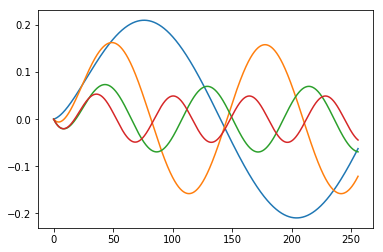

In [144]:
tau = 15 # estimated time constant (s)
y_0 = 0
K = 1
t=numpy.linspace(0.0,255.9,num=2560) # (s)

for i in range(1,5): #n_filt):
    T_s = N_V/(i*f_s_V)
    A_k = sp_V_filt[i]*2/(N_V)
    # inverting sine, because of the way I am defining the response to harmonic
    y_out = y_sin(t,T_s,tau,y_0,K,A_k)
    pyplot.plot(t, y_out.real); # output
    #pyplot.plot(t, numpy.sin(2*i*numpy.pi/T_s2*t+Phi)); # output

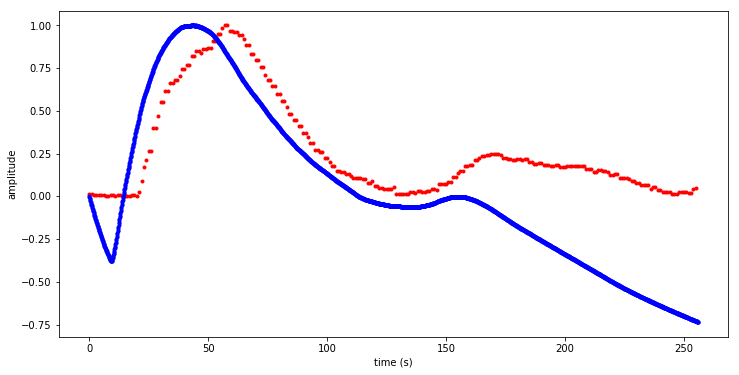

In [145]:
tau = 15 # estimated time constant (s)
y_reconstructed = numpy.zeros(N_V)
for i in range(1, 200): #n_filt):
    T_s = N_V/(i*f_s_V)
    A_k = sp_V_filt[i]*2/(N_V)
    y_reconstructed = y_reconstructed + y_sin(t,T_s,tau,y_0,K,A_k)
    
y_reconstructed = y_reconstructed 

fig = pyplot.figure(figsize=(12,6))
pyplot.plot(t_TK,TK.real,'r.')
pyplot.plot(t,y_reconstructed.real/numpy.max(y_reconstructed.real),'.b');
pyplot.xlabel('time (s)')
pyplot.ylabel('amplitude');